## Formatting the climate data
So it has named dimensions if they don't already. Also regridding to the wind_speed data grid. You can also set the starting year you want the files to run from.

In [1]:
# Libraries
%load_ext autoreload
%autoreload

import numpy as np
import iris
import iris.coord_categorisation
import pandas as pd

import sys
sys.path.append('../')
from libs.plot_maps import *


import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs

Loading in the data. Preciptation is a strange one, so we have to load in the data without trying to merge it into a single cube. We then take the first element of that cubelist. These files run from 1948 to 2019. 

In [30]:
dir_data     = '../data/aus/'
dir_outputs  = '../data/aus/'
files      = { 'air'               : 'air.mon.mean.nc',
              'relative_humidity' : 'rhum.mon.mean.nc',
               'precip'            : 'precip.mon.mean.nc'}
#                'lightning'         : 'lightn_climatology_otd_mlnha.nc',}

# Years wanted (this will produce data from the year specified until 2019)
years = 2001

input_data = {}
for key, f in files.items():
    print(key)
    try:
        dat = iris.load_cube(dir_data + f)
    except:
        # Preciptation is a weird one
        dat = iris.load(dir_data + f)
    input_data[key] = dat

air
relative_humidity
precip


In [3]:
# Load a mask
mask_file = 'uwnd.10m.gauss.2002.nc'
mask_full = iris.load_cube(dir_data + mask_file)

# We only want the mask with a single time dimension
mask = mask_full.collapsed('time', iris.analysis.MEAN)

In [17]:
# input_data['precip'] = input_data['precip'][0]

# Plot fubction
def iris_plot(wind):
    dat1 = wind.collapsed('time', iris.analysis.MEAN)
    qplt.contourf(dat1)
    plt.gca().coastlines()

### Adding a year coordinate

In [4]:
for key in input_data.keys():
    try:
        # Add coord of year
        iris.coord_categorisation.add_year(input_data[key], 'time', name='year')
    except:
        iris.coord_categorisation.add_year(input_data[key][0], 'time', name='year')

### Constraining it from `years` indicated at start

In [9]:
constrain_year = {}
for key in input_data.keys():
    try:
        constrain_year[key] = input_data[key].extract(iris.Constraint(year=lambda y: y >= years))
        print(key, constrain_year[key].coord('year'))
    except:
        constrain_year[key] = input_data[key][0].extract(iris.Constraint(year=lambda y: y >= years))
        print(key, constrain_year[key].coord('year'))

air AuxCoord(array([2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001, 2001,
       2001, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002,
       2002, 2002, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003, 2003,
       2003, 2003, 2003, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004,
       2004, 2004, 2004, 2004, 2005, 2005, 2005, 2005, 2005, 2005, 2005,
       2005, 2005, 2005, 2005, 2005, 2006, 2006, 2006, 2006, 2006, 2006,
       2006, 2006, 2006, 2006, 2006, 2006, 2007, 2007, 2007, 2007, 2007,
       2007, 2007, 2007, 2007, 2007, 2007, 2007, 2008, 2008, 2008, 2008,
       2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2009, 2009, 2009,
       2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2010, 2011,
       2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011, 2011,
       2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012,
       2012, 2013, 2013, 2013, 2013, 2

### Regridding
And adding coordinates

In [12]:
# Taking the array of the coordinates
lat = mask.coord('latitude').points
lon = mask.coord('longitude').points

# Dim coord for latitude (index: 1)
coord_lat = iris.coords.DimCoord(lat, standard_name='latitude',
                                 coord_system=iris.coord_systems.GeogCS(6371229.0),var_name='latitude',
                                 units='degrees')

# Dim coord for longitude (index: 2)
coord_lon = iris.coords.DimCoord(lon, standard_name='longitude',
                                 coord_system=iris.coord_systems.GeogCS(6371229.0),var_name='longitude',
                                 units='degrees')

In [13]:
regrid_data = {}
for key in constrain_year.keys():
    
    # Adding dimension coordinates to data
    try:        
        mask.coord('latitude').guess_bounds()
        mask.coord('longitude').guess_bounds()
    except:
        pass
    try:
        constrain_year[key].add_dim_coord(coord_lat, 1)
        constrain_year[key].add_dim_coord(coord_lon, 2)
    except:
        pass
    try:
        constrain_year[key].coord('longitude').guess_bounds()
        constrain_year[key].coord('latitude').guess_bounds()
    except:
        pass
    # Regridding the data
    regrid_data[key] = constrain_year[key].regrid(mask, iris.analysis.AreaWeighted())

### Plotting to check
This is just to check that something has happened to the data. This doesn't need to be loaded.

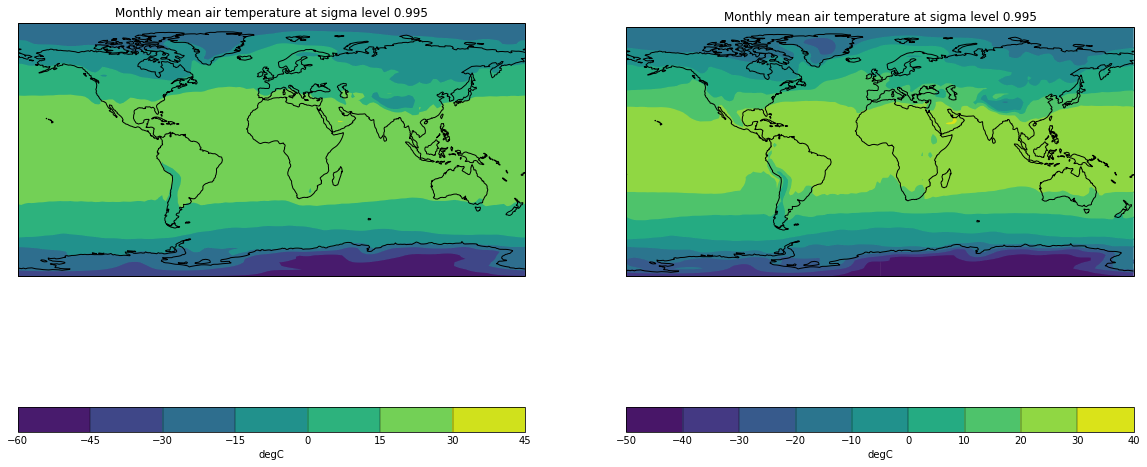

In [24]:
plt.figure(figsize = [20,16])
plt.subplot(1, 2, 1)
iris_plot(input_data['air'])
plt.subplot(1, 2, 2)
iris_plot(regrid_data['air'])

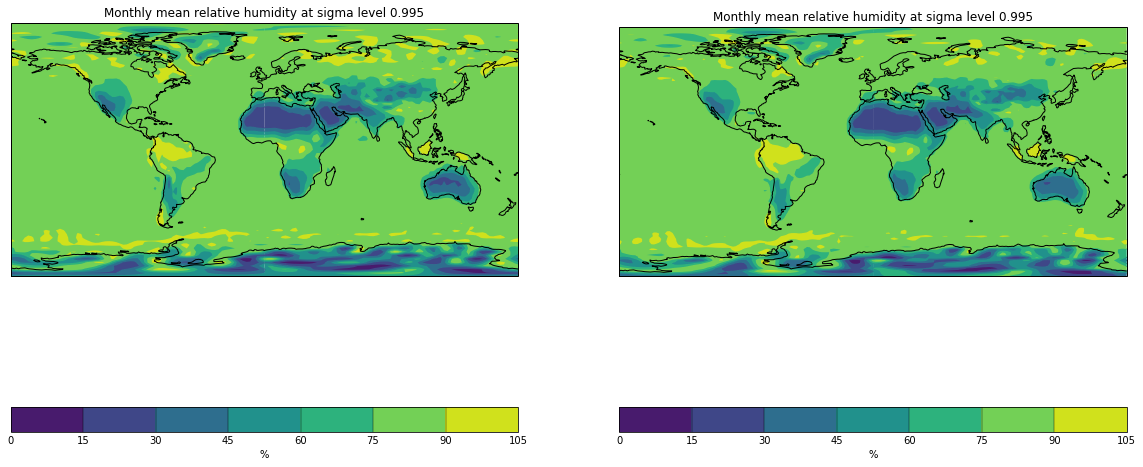

In [25]:
plt.figure(figsize = [20,16])
plt.subplot(1, 2, 1)
iris_plot(input_data['relative_humidity'])
plt.subplot(1, 2, 2)
iris_plot(regrid_data['relative_humidity'])

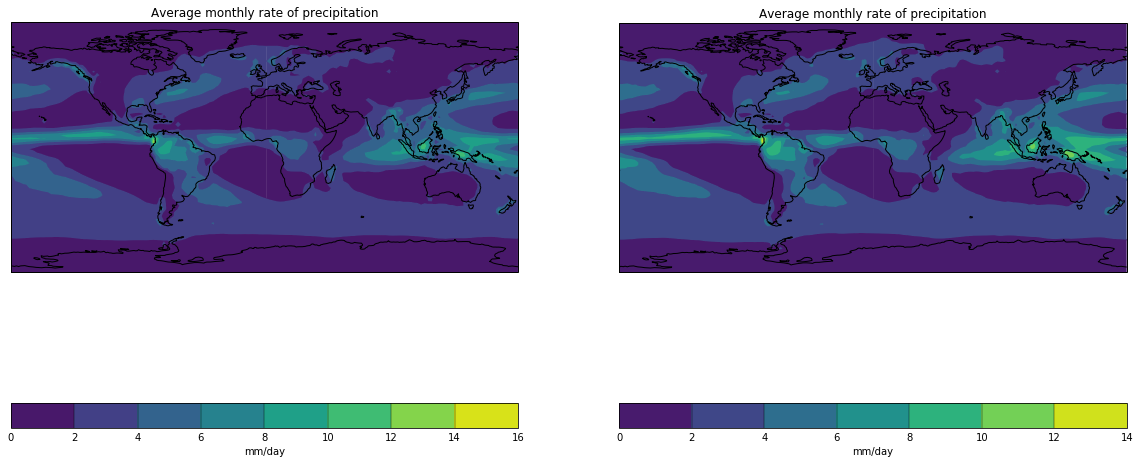

In [26]:
plt.figure(figsize = [20,16])
plt.subplot(1, 2, 1)
iris_plot(input_data['precip'][0])
plt.subplot(1, 2, 2)
iris_plot(regrid_data['precip'])

#### Saving files (all)

In [31]:
for key in regrid_data.keys():
    out = str(key) + '_' + str(years) + '-2019_test.nc'
    iris.save(regrid_data[key], dir_outputs + out)
    print(dir_outputs + out, ' saved')

../data/aus/air_2001-2019_test.nc  saved
../data/aus/relative_humidity_2001-2019_test.nc  saved
../data/aus/precip_2001-2019_test.nc  saved
